In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
destination_path = "C:/Users/gianl/Desktop/Gi/Supsi/Vaccines_Discussion_Italy/Laura/Tweets/"

In [3]:
tweets_with_urls = pd.read_parquet(destination_path+'tweets_w_urls_decompressed (1.0).parquet',
                               engine='fastparquet')

In [ ]:
tweets_with_urls.info()

In [102]:
value = []
for i in tqdm(tweets_with_urls["urls"]):
    url_exp = i.split(" ")
    lst_inside = []
    for exp in range(len(url_exp)):
        if url_exp[exp] == "'expanded_url':":
            lst_inside.append(url_exp[exp+1][1:-2])
    value.append(lst_inside)


In [103]:
def extract_domain_list(url_list):
    domain_list = []
    cont = 0
    for url in url_list:
        cont = cont + 1
        inside = []
        for i in url:
            try:
                x = i.split("/")[2]
            except:
                x = "napolimagazine.com"
            if "www." in x:
                x = x[4:]
            inside.append(x)
        domain_list.append(inside)
    return domain_list

In [104]:
x = extract_domain_list(value)

In [108]:
print(len(x))
print(len(tweets_with_urls))
tweets_with_urls["domain"] = x

1030912
1030912


In [110]:
tweets_with_urls.to_parquet(destination_path+"tweets_with_domains (2.0).parquet", index=False)

# Domain with the same name written in a different way

In [113]:
def normalize_domains(domain_list):
    for idx in range(len(domain_list)):
        domain=domain_list[idx]
        if domain in domain_normalize_df['initial_domain'].values:
            domain_list[idx] = domain_list[idx].replace(domain, domain_normalize_df[domain_normalize_df['initial_domain']==domain]['final_domain'].values[0])
    return domain_list

In [5]:
path_cred = "C:/Users/gianl/Desktop/Gi/Supsi/MartaLauraGiada/Laura/Files/"

In [66]:
#read csv with "initial_domain" and "final_domain" to substitute name of same domain expressed in different ways
domain_normalize_df = pd.read_csv(path_cred+'Domain_to_normalize.csv', sep=',')
domain_normalize_df.drop_duplicates(inplace=True)
domain_normalize_df

In [130]:
#create df with one row for every domain
domain_df = tweets_with_urls['domain'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 'value']].set_index('index') #create df of url with one url per row

# Credibility

In [56]:
path_cred = "C:/Users/gianl/Desktop/Gi/Supsi/Vaccines_Discussion_Italy/"

In [57]:
#change path and filename 
wider_cred_sources_df = pd.read_csv(path_cred+'final_urls.csv')
high_cred_df = wider_cred_sources_df[wider_cred_sources_df['credibility'] == 'high']
high_cred_df.drop_duplicates(inplace=True)
low_cred_df = wider_cred_sources_df[wider_cred_sources_df['credibility'] == 'low']
low_cred_df.drop_duplicates(inplace=True)

In [58]:
high_cred_df

,url,credibility
40,noidiminerva.it,high
43,superquark.rai.it,high
45,leganerd.com,high
49,medicisenzafrontiere.it,high
50,avvenire.it,high
...,...,...
1553,umbriajournal.com,high
1554,sardiniapost.it,high
1555,emergency-live.com,high
1556,newsmondo.it,high


In [59]:
low_cred_df

,url,credibility
0,il-quotidiano.info,low
1,terrarealtime.blogspot.com,low
2,it.sputniknews.com,low
3,laverita.info,low
4,liberoquotidiano.it,low
...,...,...
1550,teleradio-news.it,low
1552,lecronachelucane.it,low
1557,tristemondo.it,low
1559,pointofnews.it,low


In [60]:
low_cred_df = low_cred_df.rename(columns={"url": "LOW"})
high_cred_df = high_cred_df.rename(columns={"url": "HIGH"})

In [61]:
social_media_df = pd.read_excel(path_cred+'social_media_sources.xlsx')
social_media_df.drop_duplicates(inplace=True)

In [62]:
social_media_df

,SOCIAL-MEDIA
0,twitter.com
1,instagram.com
2,youtu.be
3,youtube.com
4,facebook.com
6,lnkd.in
7,t.me
8,m.facebook.com
9,t.co
10,pscp.tv


In [63]:
print(f'Possible low credibility sources = {len(low_cred_df)}')
print(f'Possible high credibility sources = {len(high_cred_df)}')
print(f'Possible social media sources = {len(social_media_df)}')

Possible low credibility sources = 1243
Possible high credibility sources = 281
Possible social media sources = 12


In [64]:
tweets_with_urls = pd.read_parquet("C:/Users/gianl/Desktop/Gi/Supsi/Vaccines_Discussion_Italy/Laura/Tweets/tweets_with_domains (2.0).parquet")
tweets_with_urls = tweets_with_urls[tweets_with_urls["in_reply_to_screen_name"].isna() & tweets_with_urls["rt_created_at"].isna() & tweets_with_urls["quoted_status_id"].isna()]

In [65]:
lst = []
lst_domains = []
for row in tqdm(tweets_with_urls.itertuples()):
    lst_inside = []
    for i in row.domain:
        lst_inside.append(i.lower())
    lst.append(len(row.domain))
    lst_domains.append(lst_inside)
tweets_with_urls["number_of_urls"] = lst
tweets_with_urls["domain"] = lst_domains

In [66]:
low = list(low_cred_df["LOW"])
high = list(high_cred_df["HIGH"])
social = list(social_media_df["SOCIAL-MEDIA"])
list_of_low = []
list_of_high = []
list_of_unkw = []
list_of_social = []
for row in tqdm(tweets_with_urls.itertuples()):
    value_low = 0
    value_high = 0
    value_unk= 0
    value_social = 0
    for domain in row.domain:
        if domain in low:
            value_low = value_low + 1 
        elif domain in high:
            value_high = value_high + 1
        elif domain in social:
            value_social = value_social + 1
        else:
            value_unk = value_unk+ 1
    list_of_low.append(value_low)
    list_of_high.append(value_high)
    list_of_unkw.append(value_unk)
    list_of_social.append(value_social)

In [67]:
tweets_with_urls['LOW'] = list_of_low
tweets_with_urls['HIGH'] = list_of_high
tweets_with_urls['UNKW'] = list_of_unkw
tweets_with_urls['SOCIAL'] = list_of_social

In [69]:
tweets_without_useless = tweets_with_urls[
    (tweets_with_urls["urls"].str.contains("twitter.com")==False) &
    (tweets_with_urls["urls"].str.contains("dlvr.it")==False) &
    (tweets_with_urls["urls"].str.contains("bit.ly")==False) &
    (tweets_with_urls["urls"].str.contains("ow.ly")==False) &
    (tweets_with_urls["urls"].str.contains("ift.tt")==False) & 
    (tweets_with_urls["urls"].str.contains("tinyurl")==False) & 
    (tweets_with_urls["urls"].str.contains("trib.al")==False) & 
    (tweets_with_urls["urls"].str.contains("zpr.io")==False) & 
    (tweets_with_urls["urls"].str.contains("is.gd")==False) &
    (tweets_with_urls["urls"].str.contains("buff.ly")==False)]

In [70]:
lst_unique = []
for i in tweets_without_useless["domain"]:
    for j in i:
        lst_unique.append(j)
cont_1 = 0
cont_2 = 0
for i in list(pd.Series(lst_unique).unique()):
    if (i in low) | (i in high) | (i in social):
        cont_1 = cont_1 + 1
    cont_2 = cont_2 + 1
print(f"Domain classified: {round(cont_1/cont_2,2)*100}%")
x = pd.Series(lst_unique).value_counts().sort_values(ascending=False)
cont1 = 0
cont2 = 0
for k,v in x.items():
    if (k in low) | (k in high) | (k in social):
        cont1 = cont1 + v
    cont2 = cont2 + v
print(f"Volume classified: {round(cont1/cont2,2)*100}%")    

Domain classified: 4.0%
Volume classified: 67.0%


In [28]:
# tweets_without_useless[tweets_without_useless["user_screen_name"].str.contains("Federica989111")]
# for i in tweets_without_useless[tweets_without_useless["user_screen_name"].str.contains("ZiaruldepeNet")]["text"]:
#     print(i)
#     print("........................")

In [71]:
lst = []
for i in tqdm(tweets_without_useless[tweets_without_useless["UNKW"]>0]["domain"]):
    for value in i:
        lst.append(value)
pd.Series(lst).value_counts().sort_values(ascending=False)[:40]

chng.it                          1607
news.google.com                  1499
flip.it                          1200
google.it                         544
paper.li                          537
msn.com                           468
informazione.it                   468
google.com                        454
go.squidapp.co                    394
notizie.virgilio.it               380
spreaker.com                      364
invst.ly                          345
tweetedtimes.com                  333
go.shr.lc                         311
f7td5.app.goo.gl                  291
profitdividend.com                282
quotidianodelsud.it               279
munben.com                        258
scansir.com                       247
larena.it                         245
raiplayradio.it                   245
ilgiunco.net                      245
it.notizie.yahoo.com              241
tmblr.co                          239
gazzettadisiena.it                237
ilcirotano.it                     230
infocilento.

In [126]:
# lst2 = []
# for i in tqdm(tweets_without_useless[tweets_without_useless["number_of_urls"]>0]["domain"]):
#     for value in i:
#         lst2.append(value)

In [72]:
sum_of_urls_df = tweets_without_useless.groupby(['user_screen_name'])[['number_of_urls','HIGH','LOW','UNKW','SOCIAL']].sum()
sum_of_urls_df=sum_of_urls_df.sort_values(by=['number_of_urls'], ascending=False)
sum_of_urls_df.head(10)

,number_of_urls,HIGH,LOW,UNKW,SOCIAL
user_screen_name,,,,,
infoitinterno,17471,33,17267,171,0
infoitsalute,16086,33,15859,194,0
infoiteconomia,6120,24,6031,65,0
zazoomblog,6033,0,6024,9,0
Notiziedi_it,3529,3529,0,0,0
IacobellisT,3475,4,1300,373,1798
Novanews242,3204,0,3184,7,13
TommyBrain,3136,3,1211,322,1600
infoitesteri,3095,17,3037,41,0


In [73]:
sum_of_urls_df.corr()

,number_of_urls,HIGH,LOW,UNKW,SOCIAL
number_of_urls,1.000000,0.260724,0.955111,0.250669,0.181668
HIGH,0.260724,1.000000,0.013242,0.090866,0.011789
LOW,0.955111,0.013242,1.000000,0.101364,0.070333
UNKW,0.250669,0.090866,0.101364,1.000000,0.162096
SOCIAL,0.181668,0.011789,0.070333,0.162096,1.000000


In [81]:
threshold_high_low = 20
sum_of_urls_df_prova = sum_of_urls_df[sum_of_urls_df['number_of_urls']>=threshold_high_low]

In [82]:
sum_of_urls_df_prova['conspiracy_score'] = np.around(((sum_of_urls_df_prova['LOW'])/(sum_of_urls_df_prova['HIGH']+sum_of_urls_df_prova['LOW'])),2)
sum_of_urls_df_prova=sum_of_urls_df_prova.sort_values(by=['conspiracy_score'], ascending=False)
sum_of_urls_df_prova.head(10)

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score
user_screen_name,,,,,,
infoitinterno,17471,33,17267,171,0,1.0
CDonChisciotte,117,0,117,0,0,1.0
Toba_60,266,0,266,0,0,1.0
simpli_cissimus,64,0,64,0,0,1.0
fainformazione,258,0,257,1,0,1.0
pointofnews,251,1,250,0,0,1.0
PecheanuA,23,0,3,20,0,1.0
tristemondo,248,0,248,0,0,1.0
abruzzoweb,40,0,40,0,0,1.0


In [161]:
sum_of_urls_df_prova.to_csv(destination_path+"result_cred_score_thresh_20.csv", 
                            index=True, encoding="utf-8", line_terminator="\n")

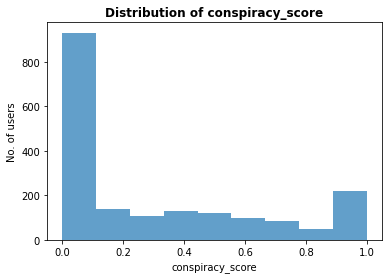

In [83]:
# distribution of scores
plt.hist(list(sum_of_urls_df_prova['conspiracy_score']), bins=9, alpha=0.7)
plt.xlabel('conspiracy_score')
plt.ylabel('No. of users')
plt.title('Distribution of conspiracy_score', weight='bold')
#plt.savefig('plots/dist', bbox_inches='tight')
plt.show()

In [84]:
sum_of_urls_df_prova.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2850 entries, infoitinterno to news_ferrara
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number_of_urls    2850 non-null   int64  
 1   HIGH              2850 non-null   int64  
 2   LOW               2850 non-null   int64  
 3   UNKW              2850 non-null   int64  
 4   SOCIAL            2850 non-null   int64  
 5   conspiracy_score  1883 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 155.9+ KB


In [91]:
print(len(sum_of_urls_df_prova)-len(sum_of_urls_df_prova[sum_of_urls_df_prova["conspiracy_score"].notna()]))
sum_of_urls_df_prova.head(20)

967


,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score
user_screen_name,,,,,,
infoitinterno,17471,33,17267,171,0,1.0
CDonChisciotte,117,0,117,0,0,1.0
Toba_60,266,0,266,0,0,1.0
simpli_cissimus,64,0,64,0,0,1.0
fainformazione,258,0,257,1,0,1.0
pointofnews,251,1,250,0,0,1.0
PecheanuA,23,0,3,20,0,1.0
tristemondo,248,0,248,0,0,1.0
abruzzoweb,40,0,40,0,0,1.0


In [92]:
sum_of_urls_df_prova[sum_of_urls_df_prova["conspiracy_score"]>=0.50]

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score
user_screen_name,,,,,,
infoitinterno,17471,33,17267,171,0,1.0
CDonChisciotte,117,0,117,0,0,1.0
Toba_60,266,0,266,0,0,1.0
simpli_cissimus,64,0,64,0,0,1.0
fainformazione,258,0,257,1,0,1.0
...,...,...,...,...,...,...
Gesefi_onlus_it,24,6,6,12,0,0.5
Iridediluce,24,4,4,8,8,0.5
Stefano15067453,28,2,2,6,18,0.5


In [93]:
sum_of_urls_df = sum_of_urls_df_prova

In [94]:
median = np.median(np.asarray(sum_of_urls_df_prova['conspiracy_score'].dropna()))
median

0.12

In [244]:
t = 0.5
conditions = (sum_of_urls_df['conspiracy_score']<t)
sum_of_urls_df['credibility_classification'] = np.where(conditions , 'credible', 'NON credible')
sum_of_urls_df.head()

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification
user_screen_name,,,,,,,
diego101garcia,15,0,15,0,0,1.0,NON credible
PierTossani,36,0,36,0,0,1.0,NON credible
romfrares,90,0,54,0,36,1.0,NON credible
Dario70864607,18,0,11,3,4,1.0,NON credible
LucianoTiramani,19,0,15,4,0,1.0,NON credible


In [245]:
len(sum_of_urls_df)

4524

In [246]:
non_cred = sum_of_urls_df[sum_of_urls_df['credibility_classification']== 'NON credible']

In [247]:
cred = sum_of_urls_df[sum_of_urls_df['credibility_classification']== 'credible']

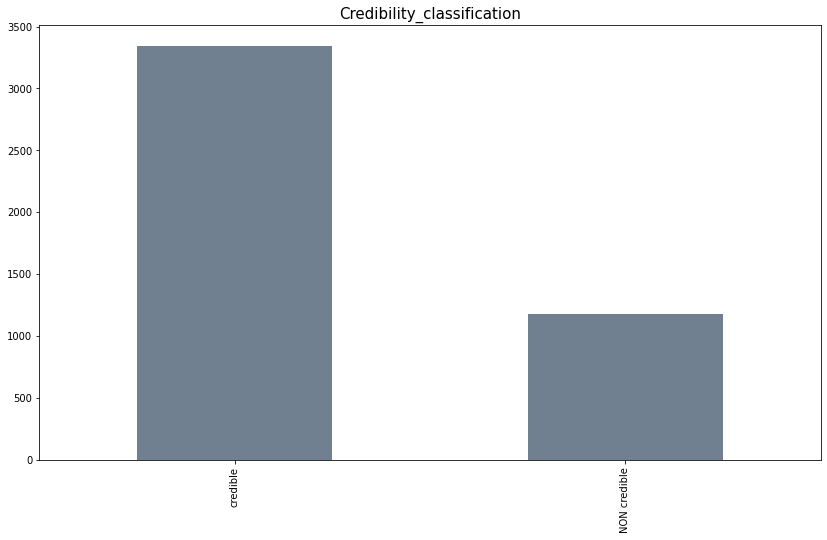

In [262]:
fig = plt.figure(figsize=(14, 8))
ax = sum_of_urls_df['credibility_classification'].value_counts(ascending=False)[:30].plot(kind='bar', color='slategrey', fig=(14,14)) #slategrey
ax.set_title('Credibility_classification', fontsize=15)
# ax.invert_yaxis()
plt.show()

In [261]:
sum_of_urls_df

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification
user_screen_name,,,,,,,
diego101garcia,15,0,15,0,0,1.0,NON credible
PierTossani,36,0,36,0,0,1.0,NON credible
romfrares,90,0,54,0,36,1.0,NON credible
Dario70864607,18,0,11,3,4,1.0,NON credible
LucianoTiramani,19,0,15,4,0,1.0,NON credible
...,...,...,...,...,...,...,...
AvvDox,22,10,0,3,9,0.0,credible
marco__lecce,22,13,0,5,4,0.0,credible
em_eraldsea,15,10,0,1,4,0.0,credible


In [249]:
sum_of_urls_df['credibility_classification'].unique()

array(['NON credible', 'credible'], dtype=object)

In [264]:
sum_of_urls_df['user'] = sum_of_urls_df.index

In [265]:
sum_of_urls_df.to_csv(destination_path+"result_credibility.csv", index=False)

# USER ERROR

In [253]:
path_error = '/content/gdrive/My Drive/SUPSI/CSN_Project/'

In [254]:
user_error_df = pd.read_csv(path_error+'user_error_df.csv', lineterminator='\n')

In [255]:
user_error_df

,id,id_str,name,screen_name,code
0,560086917,560086917,Pietro Ragno,ThePRagno88,NaN
1,1140596424,1140596424,Gabry Albertini,ALBERTINIGabry,NaN
2,470349216,470349216,vito vitalozzo,vitalozzo2012,NaN
3,1006547627549319169,1006547627549319169,Nicolò Montarini,nicolomontarini,NaN
4,1304095580868636679,1304095580868636679,Hemal khan,Hemalkh90149688,NaN
...,...,...,...,...,...
286811,960163091676774401,960163091676774401,Yo＄hi,4416tksw,NaN
286812,533587191,533587191,Hair Straightening,RadianceSALON_,NaN
286813,1128241290,1128241290,Giovanni Bonomo,gbonomo1,NaN
286814,1018828109053943810,1018828109053943810,vincibellomo,vincibellomo,NaN


In [ ]:
sum_of_urls_df

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification
user_screen_name,,,,,,,
lucianotiramani,12,0,10,2,0,1.0,NON credible
salernonotizie,758,0,757,1,0,1.0,NON credible
fabrizi58277161,56,0,10,12,34,1.0,NON credible
paulus00767325,17,0,17,0,0,1.0,NON credible
avg,46,0,46,0,0,1.0,NON credible
...,...,...,...,...,...,...,...
franzrusso,44,14,0,28,2,0.0,credible
cassio39592131,44,26,0,13,5,0.0,credible
bettasanlazzaro,44,18,0,11,15,0.0,credible


In [257]:
sum_of_urls_df

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification
user_screen_name,,,,,,,
diego101garcia,15,0,15,0,0,1.0,NON credible
PierTossani,36,0,36,0,0,1.0,NON credible
romfrares,90,0,54,0,36,1.0,NON credible
Dario70864607,18,0,11,3,4,1.0,NON credible
LucianoTiramani,19,0,15,4,0,1.0,NON credible
...,...,...,...,...,...,...,...
AvvDox,22,10,0,3,9,0.0,credible
marco__lecce,22,13,0,5,4,0.0,credible
em_eraldsea,15,10,0,1,4,0.0,credible


In [ ]:
users = users.rename(columns={"screen_name": "user_screen_name"})

In [ ]:
sum_of_urls_df_compl = sum_of_urls_df.merge(users, how='left',on='user_screen_name')

In [ ]:
sum_of_urls_df_compl

,user_screen_name,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification,id,id_str,name,location,description,url,protected,followers_count,friends_count,listed_count,created_at,favourites_count,geo_enabled,verified,statuses_count,contributors_enabled,default_profile,default_profile_image
0,lucianotiramani,12,0,10,2,0,1.0,NON credible,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172867.0,False,False,False
2,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172869.0,False,False,False
3,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172869.0,False,False,False
4,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172869.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22233,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71378.0,True,False,51915.0,False,False,False
22234,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71379.0,True,False,51917.0,False,False,False
22235,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71380.0,True,False,51918.0,False,False,False
22236,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71380.0,True,False,51918.0,False,False,False


In [ ]:
sum_of_urls_df_compl

,user_screen_name,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification,id,id_str,name,location,description,url,protected,followers_count,friends_count,listed_count,created_at,favourites_count,geo_enabled,verified,statuses_count,contributors_enabled,default_profile,default_profile_image
0,lucianotiramani,12,0,10,2,0,1.0,NON credible,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172867.0,False,False,False
2,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172869.0,False,False,False
3,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172869.0,False,False,False
4,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172869.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22233,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71378.0,True,False,51915.0,False,False,False
22234,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71379.0,True,False,51917.0,False,False,False
22235,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71380.0,True,False,51918.0,False,False,False
22236,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71380.0,True,False,51918.0,False,False,False


In [ ]:
sum_of_urls_df_compl.to_csv(path_url+"sum_of_urls_df_compl.csv", index=False)

In [ ]:
sum_of_urls_df_compl_info = sum_of_urls_df_compl.merge(user_error_df, how='left',on='id')

In [ ]:
selected_columns_users = sum_of_urls_df_compl_info[["id",	"screen_name", "code", "number_of_urls",	"HIGH",	"LOW",	"UNKW",	"SOCIAL",	"conspiracy_score",	"credibility_classification"]]

info_on_users = selected_columns_users.copy()

In [ ]:
info_on_users

,id,screen_name,code,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification
0,NaN,NaN,NaN,12,0,10,2,0,1.0,NON credible
1,294773912.0,salernonotizie,NaN,758,0,757,1,0,1.0,NON credible
2,294773912.0,salernonotizie,NaN,758,0,757,1,0,1.0,NON credible
3,294773912.0,salernonotizie,NaN,758,0,757,1,0,1.0,NON credible
4,294773912.0,salernonotizie,NaN,758,0,757,1,0,1.0,NON credible
...,...,...,...,...,...,...,...,...,...,...
22233,46922585.0,tixxxtweety,NaN,44,14,0,2,28,0.0,credible
22234,46922585.0,tixxxtweety,NaN,44,14,0,2,28,0.0,credible
22235,46922585.0,tixxxtweety,NaN,44,14,0,2,28,0.0,credible
22236,46922585.0,tixxxtweety,NaN,44,14,0,2,28,0.0,credible


In [ ]:
len(info_on_users[info_on_users['code'].notna()])

59

In [ ]:
info_on_users[info_on_users['code'].notna()].drop_duplicates()

,id,screen_name,code,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification
6474,3.159375e+09,venetolink,63.0,186,20,15,26,125,0.43,credible
10706,1.032863e+18,giusepp69152402,63.0,21,8,2,6,5,0.20,credible
11769,4.125886e+09,geremia767,63.0,68,15,2,18,33,0.12,credible
13797,2.304070e+08,hurried57,50.0,32,19,1,12,0,0.05,credible
17186,2.333459e+08,bicidiario,50.0,81,13,0,25,43,0.00,credible
